In [1]:
# Install the packages
! pip install --upgrade google-genai google-cloud-storage requests matplotlib pillow tqdm tenacity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 102.8 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: pillow
    Found existing installation: pillow 11.1.0
    Uninstalling pillow-11.1.0:
      Successfully uninstalled pillow-11.1.0
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.19.0
    Uninstalling google-cloud-storage-2.19.0:
      Successfully uninstalled google-cloud-storage-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the follo

In [2]:
# Install the packages
! pip install google-cloud-vision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.1/526.1 kB 12.2 MB/s eta 0:00:00


In [3]:
# Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
PROJECT = !gcloud config get-value project
PROJECT_ID = PROJECT[0]
REGION = "us-central1"

In [2]:
BUCKET_URI = f"gs://artifacts-{PROJECT_ID}-unique"  # @param {type:"string"}

In [3]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://artifacts-qwiklabs-gcp-00-75d53150ff49-unique/...


In [4]:
! git clone https://github.com/poloclub/diffusiondb

Cloning into 'diffusiondb'...
remote: Enumerating objects: 448, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 448 (delta 31), reused 55 (delta 16), pack-reused 369 (from 1)
Receiving objects: 100% (448/448), 7.02 MiB | 17.00 MiB/s, done.
Resolving deltas: 100% (245/245), done.


In [5]:
! pip install -r diffusiondb/requirements.txt

  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210137 sha256=1c612e1c90eefa791837daeef89790b4fe0e6690eb7a279003ebb2b0230ca7f7
  Stored in directory: /home/jupyter/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [6]:
# Download image files from 1. The file contains of 1000 images.
! python diffusiondb/scripts/download.py -i 2 -r 3

In [7]:
# Unzip all image files
image_directory = "extracted"

! unzip -n 'images/*.zip' -d '{image_directory}'

Archive:  images/part-000002.zip
  inflating: extracted/aa47f55f-c538-4229-b9e8-0226f406623b.png  
  inflating: extracted/18f8dd4b-5fcc-4eeb-8f4b-1a31ba596571.png  
  inflating: extracted/4ebef39c-3f7e-44ee-af88-56d0a4d15322.png  
  inflating: extracted/ae14ea71-a528-4832-aa1f-f4eed20f6e7b.png  
  inflating: extracted/5613b220-5601-4fcc-8273-b617945b5fb2.png  
  inflating: extracted/cf4050c0-09be-4999-a744-078c11eabb02.png  
  inflating: extracted/ddd0c059-e56a-4340-b99c-fbf8cd953edf.png  
  inflating: extracted/d5c62f9e-42ee-4a57-94c1-aae2e33ebedd.png  
  inflating: extracted/9b0d48a8-5663-4ce0-98b4-c50f79df6016.png  
  inflating: extracted/09985df9-a0f4-4d55-aa52-3d5400c4cd14.png  
  inflating: extracted/731aee6f-4ec8-4750-bb52-228a5fdfe273.png  
  inflating: extracted/2fcfc412-5ebe-455a-a6ea-3d6e2209d6a7.png  
  inflating: extracted/d35ff4c6-4618-4092-a702-75eb351a4daf.png  
  inflating: extracted/17160727-11c0-499e-b68b-d1bdca58d02d.png  
  inflating: extracted/c316eee9-5a95-46f8-9

In [8]:
import json
import os

metadatas = {}
for file_name in os.listdir(image_directory):
    if file_name.endswith(".json"):
        with open(os.path.join(image_directory, file_name)) as f:
            metadata_chunk = json.load(f)
            metadatas.update(metadata_chunk)

# Get image names and paths from the loaded metadata
image_names_all = list(metadatas.keys())
image_paths_all = [os.path.join(image_directory, image_name) for image_name in image_names_all]

len(metadatas)

1000

In [9]:
from typing import Optional

from google.cloud import vision
from google.cloud.vision_v1.types.image_annotator import SafeSearchAnnotation

client = vision.ImageAnnotatorClient()


def detect_safe_search(path: str) -> Optional[SafeSearchAnnotation]:
    """Detects unsafe features in the file."""

    with open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.safe_search_detection(image=image)

    if response.error.message:
        print(response.error.message)
        return None

    return response.safe_search_annotation

In [10]:
from google.cloud.vision_v1.types.image_annotator import Likelihood


# Returns true if some annotations have a potential safety issues
def convert_annotation_to_safety(safe_search_annotation: SafeSearchAnnotation) -> bool:
    return all(
        [
            (safe_level == Likelihood.VERY_UNLIKELY)
            or (safe_level == Likelihood.UNLIKELY)
            for safe_level in [
                safe_search_annotation.adult,
                safe_search_annotation.medical,
                safe_search_annotation.violence,
                safe_search_annotation.racy,
            ]
        ]
    )

In [11]:
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Optional

import numpy as np
from tqdm import tqdm

# Create a rate limiter with a limit of 1800 requests per minute
seconds_per_job = 1 / (1800 / 60)


def process_image(image_path: str) -> Optional[bool]:
    try:
        annotation = detect_safe_search(image_path)

        if annotation:
            return convert_annotation_to_safety(safe_search_annotation=annotation)
        else:
            return None
    except Exception:
        return None


# Process images using ThreadPool
is_safe_values_cloud_vision = []
with ThreadPoolExecutor() as executor:
    futures = []
    for img_url in tqdm(image_paths_all, total=len(image_paths_all), position=0):
        futures.append(executor.submit(process_image, img_url))
        time.sleep(seconds_per_job)

    for future in futures:
        is_safe_values_cloud_vision.append(future.result())

# Set Nones to False
is_safe_values_cloud_vision = [
    is_safe or False for is_safe in is_safe_values_cloud_vision
]

# Print number of safe images found
print(
    f"Safe images = {np.array(is_safe_values_cloud_vision).sum()} out of {len(is_safe_values_cloud_vision)} images"
)

100%|██████████| 1000/1000 [00:34<00:00, 29.23it/s]


Safe images = 711 out of 1000 images


In [12]:
# Filter images by safety
metadatas = [
    metadata
    for metadata, is_safe in zip(metadatas, is_safe_values_cloud_vision)
    if is_safe
]
image_names = [
    image_name
    for image_name, is_safe in zip(image_names_all, is_safe_values_cloud_vision)
    if is_safe
]
image_paths = [
    image_path
    for image_path, is_safe in zip(image_paths_all, is_safe_values_cloud_vision)
    if is_safe
]

In [13]:
import base64
import time
import typing
import requests # Make sure requests is imported
import numpy as np

from google.cloud import aiplatform
from google.protobuf import struct_pb2


class EmbeddingResponse(typing.NamedTuple):
    text_embedding: typing.Sequence[float]
    image_embedding: typing.Sequence[float]


def load_image_bytes(image_uri: str) -> bytes:
    """Load image bytes from a local URI."""
    # This lab only uses local files, so simplify.
    with open(image_uri, "rb") as image_file:
        image_bytes = image_file.read()
    return image_bytes


class EmbeddingPredictionClient:
    """Wrapper around Prediction Service Client."""

    def __init__(
        self,
        project: str,
        location: str = "us-central1",
        api_regional_endpoint: str = "us-central1-aiplatform.googleapis.com",
    ):
        client_options = {"api_endpoint": api_regional_endpoint}
        self.client = aiplatform.gapic.PredictionServiceClient(
            client_options=client_options
        )
        self.location = location
        self.project = project

    def get_embedding(self, text: str = None, image_file: str = None):
        if not text and not image_file:
            raise ValueError("At least one of text or image_file must be specified.")

        # Load image file if provided
        image_bytes = None
        if image_file:
            image_bytes = load_image_bytes(image_file)

        instance = struct_pb2.Struct()
        if text:
            instance.fields["text"].string_value = text

        if image_bytes:
            encoded_content = base64.b64encode(image_bytes).decode("utf-8")
            image_struct = instance.fields["image"].struct_value
            image_struct.fields["bytesBase64Encoded"].string_value = encoded_content

        instances = [instance]
        endpoint = (
            f"projects/{self.project}/locations/{self.location}"
            "/publishers/google/models/multimodalembedding@001"
        )
        response = self.client.predict(endpoint=endpoint, instances=instances)

        text_embedding = None
        if text:
            # Check if textEmbedding field exists and is not None
            if "textEmbedding" in response.predictions[0] and response.predictions[0]["textEmbedding"]:
                text_emb_value = response.predictions[0]["textEmbedding"]
                text_embedding = [v for v in text_emb_value]


        image_embedding = None
        if image_bytes:
            # Check if imageEmbedding field exists and is not None
            if "imageEmbedding" in response.predictions[0] and response.predictions[0]["imageEmbedding"]:
                image_emb_value = response.predictions[0]["imageEmbedding"]
                image_embedding = [v for v in image_emb_value]

        return EmbeddingResponse(
            text_embedding=text_embedding, image_embedding=image_embedding
        )

In [14]:
import time
from concurrent.futures import ThreadPoolExecutor
from typing import Callable, Generator, List, Optional
from tqdm.auto import tqdm # Use tqdm.auto for notebook compatibility
from tenacity import retry, stop_after_attempt, wait_fixed # Import wait_fixed

def generate_batches(
    inputs: List[str], batch_size: int
) -> Generator[List[str], None, None]:
    """
    Generator function that takes a list of strings and a batch size, and yields batches of the specified size.
    """
    for i in range(0, len(inputs), batch_size):
        yield inputs[i : i + batch_size]

ACTUAL_API_RATE_RPM = 10
API_ITEMS_PER_SECOND = ACTUAL_API_RATE_RPM / 60

def encode_to_embeddings_chunked(
    process_function: Callable[[List[str]], List[Optional[List[float]]]],
    items: List[str],
    batch_size: int = 1, # Multimodal embedding model currently supports batch_size=1
) -> List[Optional[List[float]]]:
    """
    Function that encodes a list of strings (or image paths) into embeddings using a process function.
    It takes a list of items and returns a list of optional lists of floats.
    The data is processed in chunks with rate limiting.
    """
    embeddings_list: List[Optional[List[float]]] = []

    # Prepare the batches using a generator (batch size is 1 for this model)
    batches = generate_batches(items, batch_size)

    # Calculate sleep time between batches based on the *actual* API rate
    seconds_per_batch = batch_size / API_ITEMS_PER_SECOND if API_ITEMS_PER_SECOND > 0 else 0 # Avoid division by zero

    print(f"Processing {len(items)} items in batches of {batch_size}...")
    print(f"Rate limit: {ACTUAL_API_RATE_RPM} RPM ({API_ITEMS_PER_SECOND:.2f} req/sec)")
    print(f"Sleeping for {seconds_per_batch:.2f} seconds between batches.")


    with ThreadPoolExecutor(max_workers=5) as executor: # Limit concurrent workers
        futures = []
        # Use tqdm for progress bar
        for batch in tqdm(batches, total=len(items) // batch_size + (len(items) % batch_size > 0), desc="Encoding Batches"):
            # Note: The multimodalembedding model often processes 1 item per request
            # The batch argument here is typically a list of length 1 for this model.
            futures.append(executor.submit(process_function, batch))
            time.sleep(seconds_per_batch) # Respect the rate limit

        # Collect results
        for future in tqdm(futures, desc="Collecting Results"):
            embeddings_list.extend(future.result())

    return embeddings_list

In [15]:
import copy
from typing import List, Optional

@retry(reraise=True, stop=stop_after_attempt(3), wait=wait_fixed(5))
def encode_texts_to_embeddings_with_retry(text: List[str]) -> List[List[float]]:
    # Assert that the input list has only one item, as required by the function
    assert len(text) == 1, "encode_texts_to_embeddings_with_retry expects a list with a single text item."

    try:
        # Call the embedding client for a single text input
        embedding_response = client.get_embedding(text=text[0], image_file=None)
        if embedding_response.text_embedding is None:
            # This might happen if the API didn't return a text embedding for some reason
            print(f"Warning: No text embedding returned for text: {text[0]}")
            return [None]
        return [list(embedding_response.text_embedding)] # Return as List[List[float]]
    except Exception as e:
        # Catch specific API errors if needed, but general exception is okay for lab
        print(f"Error getting text embedding for '{text[0]}': {e}")
        raise RuntimeError(f"Error getting text embedding: {e}") # Re-raise to trigger retry

def encode_texts_to_embeddings(text: List[str]) -> List[Optional[List[float]]]:
    # This function handles the retry wrapper and returns [None] on final failure
    if not text:
        return []
    try:
        results = []
        for t in text:
            # Note: We call encode_texts_to_embeddings_with_retry with a list containing one item
            embedding_result = encode_texts_to_embeddings_with_retry(text=[t])
            results.extend(embedding_result) # extend because retry returns a list of results
        return results
    except Exception as ex:
        print(f"Failed after retries for texts: {text}. Error: {ex}")
        return [None for _ in range(len(text))] # Return None for all inputs on final failure


@retry(reraise=True, stop=stop_after_attempt(3), wait=wait_fixed(5))
def encode_images_to_embeddings_with_retry(image_uris: List[str]) -> List[List[float]]:
    # Assert that the input list has only one item, as required by the function
    assert len(image_uris) == 1, "encode_images_to_embeddings_with_retry expects a list with a single image uri."

    try:
        # Call the embedding client for a single image input
        embedding_response = client.get_embedding(text=None, image_file=image_uris[0])
        if embedding_response.image_embedding is None:
            # This might happen if the API didn't return an image embedding for some reason
            print(f"Warning: No image embedding returned for image: {image_uris[0]}")
            return [None]
        return [list(embedding_response.image_embedding)] # Return as List[List[float]]
    except Exception as ex:
        print(f"Error getting image embedding for '{image_uris[0]}': {ex}")
        raise RuntimeError(f"Error getting image embedding: {ex}") # Re-raise to trigger retry


def encode_images_to_embeddings(image_uris: List[str]) -> List[Optional[List[float]]]:
    # This function handles the retry wrapper and returns [None] on final failure
    if not image_uris:
        return []
    try:
        results = []
        for uri in image_uris:
            # Note: We call encode_images_to_embeddings_with_retry with a list containing one item
            embedding_result = encode_images_to_embeddings_with_retry(image_uris=[uri])
            results.extend(embedding_result) # extend because retry returns a list of results
        return results
    except Exception as ex:
        print(f"Failed after retries for image URIs: {image_uris}. Error: {ex}")
        return [None for _ in range(len(image_uris))] # Return None for all inputs on final failure


# Initialize the client here after defining the class
client = EmbeddingPredictionClient(project=PROJECT_ID, location=REGION)

In [16]:
%%time
# Encode a SAMPLE subset of images for testing.
TEST_SAMPLE_SIZE = 50
image_paths_test_sample = list(image_paths_all)[:TEST_SAMPLE_SIZE]

print(f"Encoding a test sample of {TEST_SAMPLE_SIZE} images...")

# Use the chunked encoder which includes the rate limiter
image_embeddings_test = encode_to_embeddings_chunked(
    process_function=encode_images_to_embeddings,
    items=image_paths_test_sample,
    batch_size=1 # Multimodal embedding model requires batch size 1
)

# Keep only non-None embeddings from the test sample
indexes_to_keep_test, image_embeddings_test_filtered = zip(
    *[
        (index, embedding)
        for index, embedding in enumerate(image_embeddings_test)
        if embedding is not None
    ]
) if any(e is not None for e in image_embeddings_test) else ([], []) # Handle case where all are None


print(f"Processed {len(image_embeddings_test_filtered)} test embeddings successfully")
if len(image_embeddings_test_filtered) > 0:
    print(f"First test embedding dimension: {len(image_embeddings_test_filtered[0])}")
else:
    print("No test embeddings were successfully generated.")

Encoding a test sample of 50 images...
Processing 50 items in batches of 1...
Rate limit: 10 RPM (0.17 req/sec)
Sleeping for 6.00 seconds between batches.


Encoding Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Processed 50 test embeddings successfully
First test embedding dimension: 1408
CPU times: user 1.05 s, sys: 209 ms, total: 1.26 s
Wall time: 5min


In [17]:
import numpy as np

def dot_product_distance(
    text_embedding: np.ndarray, image_embeddings: np.ndarray
) -> np.ndarray:
    """Compute dot-product distance between text and image embeddings by taking the dot product"""
    # Ensure inputs are numpy arrays
    text_embedding = np.asarray(text_embedding)
    image_embeddings = np.asarray(image_embeddings)

    if text_embedding.ndim == 1:
        text_embedding = text_embedding.reshape(1, -1)

    if image_embeddings.ndim == 1:
        image_embeddings = image_embeddings.reshape(1, -1)
    elif image_embeddings.ndim > 2:
        raise ValueError("image_embeddings must be 1D or 2D array.")

    distances = np.dot(text_embedding, image_embeddings.T).squeeze()

    return np.atleast_1d(distances)

Successfully generated embedding for query: 'Birds in flight'
Calculating distances for 50 test embeddings.


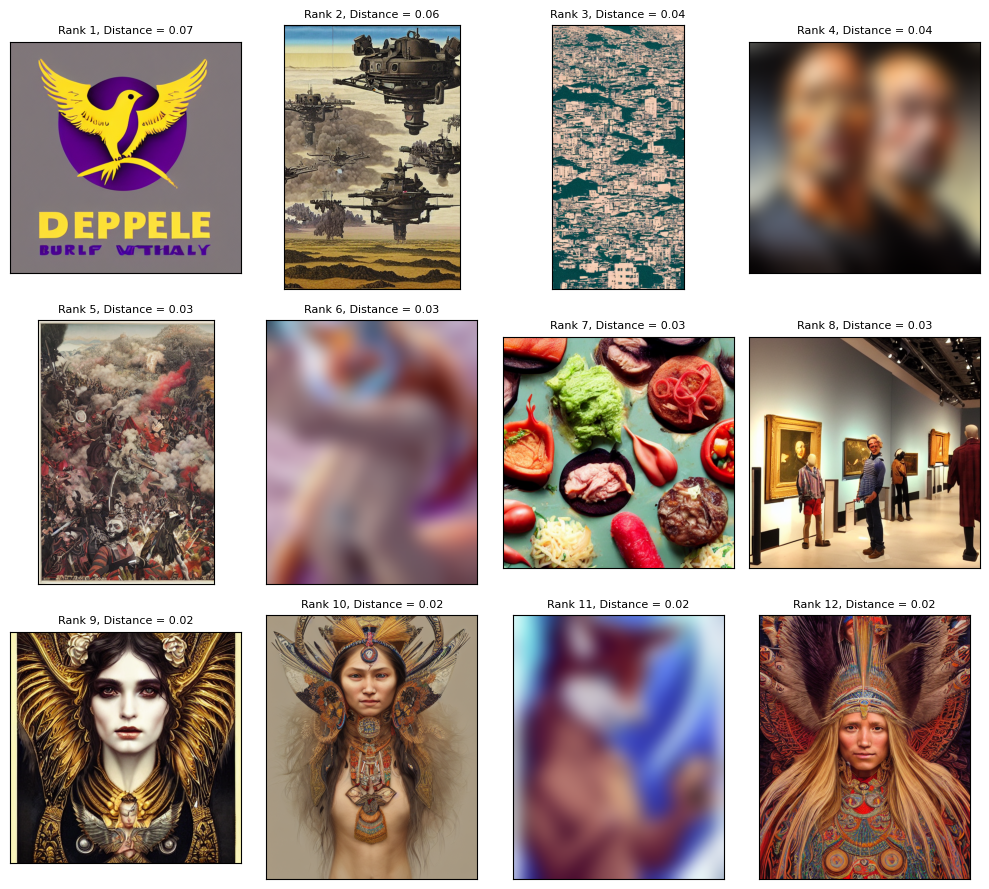

In [18]:
import math
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image # Import Image

text_query = "Birds in flight"

# Calculate text embedding of query (uses 1 API call)
text_embedding_query_list = encode_texts_to_embeddings(text=[text_query])

if not text_embedding_query_list or text_embedding_query_list[0] is None:
    print(f"Failed to get embedding for query: '{text_query}'. Cannot perform search.")
else:
    text_embedding_query = text_embedding_query_list[0]
    print(f"Successfully generated embedding for query: '{text_query}'")

    if len(image_embeddings_test_filtered) > 0:
        print(f"Calculating distances for {len(image_embeddings_test_filtered)} test embeddings.")
        distances = dot_product_distance(
            text_embedding=np.array(text_embedding_query),
            image_embeddings=np.array(image_embeddings_test_filtered) # Use the filtered test embeddings
        )

        image_paths_test_filtered = [image_paths_test_sample[i] for i in indexes_to_keep_test]

        MAX_IMAGES_DISPLAY = 12

        sorted_data = sorted(
            zip(image_paths_test_filtered, distances), key=lambda x: x[1], reverse=True
        )[:MAX_IMAGES_DISPLAY]

        # Calculate the number of rows and columns needed to display the images
        num_cols_display = 4
        num_rows_display = math.ceil(len(sorted_data) / num_cols_display)


        # Create a grid of subplots to display the images
        fig, axs = plt.subplots(nrows=num_rows_display, ncols=num_cols_display, figsize=(10, num_rows_display * 3))
        axs = axs.flatten() # Flatten the 2D array of axes for easy iteration

        # Loop through the top images and display them
        for i, (image_path, distance) in enumerate(sorted_data):
            ax = axs[i] # Get the current axis

            try:
                # Load image - we know these are local files
                image = Image.open(image_path).convert('RGB') # Convert to RGB to handle grayscale/palette

                # Display the image
                ax.imshow(image)

                # Set the title
                ax.set_title(f"Rank {i+1}, Distance = {distance:.2f}", fontsize=8) # Reduced font size

                # Remove ticks
                ax.set_xticks([])
                ax.set_yticks([])
            except Exception as e:
                print(f"Could not load or display image {image_path}: {e}")
                ax.set_title("Error Loading Image", fontsize=8)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


        # Hide any unused subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])


        # Adjust spacing and display
        plt.tight_layout() # Use tight_layout for better spacing
        plt.show()

    else:
        print("No valid image embeddings available from the test sample to visualize search.")

In [19]:
DIMENSIONS = len(image_embeddings_test_filtered[0])

print(f"Embedding Dimensions: {DIMENSIONS}")

Embedding Dimensions: 1408


In [20]:
import tempfile
import os

embeddings_file = tempfile.NamedTemporaryFile(suffix=".json", delete=False)
embeddings_file.close()

embeddings_file_path = embeddings_file.name

print(f"Created temporary file path with .json suffix: {embeddings_file_path}")

Created temporary file path with .json suffix: /var/tmp/tmptdsdsmsr.json


In [21]:
import json
import os

IMAGES_FOR_INDEXING = 200

image_names_for_indexing = image_names_all[:IMAGES_FOR_INDEXING]
image_paths_for_indexing = image_paths_all[:IMAGES_FOR_INDEXING]

print(f"\nEncoding {len(image_paths_for_indexing)} images for the index...")

embeddings_for_indexing = encode_to_embeddings_chunked(
    process_function=encode_images_to_embeddings,
    items=image_paths_for_indexing,
    batch_size=1
)

print(f"\nWriting embeddings to {embeddings_file_path}...")
successful_embeddings_count = 0
with open(embeddings_file_path, "w") as f:
    for i, embedding in enumerate(embeddings_for_indexing):
        if embedding is not None:
            image_name = image_names_for_indexing[i]
            embedding_formatted = [float(value) for value in embedding]
            json_entry = {
                "id": str(image_name),
                "embedding": embedding_formatted,
            }
            f.write(json.dumps(json_entry) + "\n")
            successful_embeddings_count += 1

print(f"Finished encoding and writing. Successfully generated and wrote {successful_embeddings_count} embeddings.")
if successful_embeddings_count == 0:
    print("WARNING: No embeddings were successfully generated. Check the API calls above for errors (quota?).")


Encoding 200 images for the index...
Processing 200 items in batches of 1...
Rate limit: 10 RPM (0.17 req/sec)
Sleeping for 6.00 seconds between batches.


Encoding Batches:   0%|          | 0/200 [00:00<?, ?it/s]


Writing embeddings to /var/tmp/tmptdsdsmsr.json...
Finished encoding and writing. Successfully generated and wrote 200 embeddings.


In [22]:
UNIQUE_FOLDER_NAME = "embeddings_folder_unique"
EMBEDDINGS_INITIAL_URI = f"{BUCKET_URI}/{UNIQUE_FOLDER_NAME}/"
! gsutil cp {embeddings_file_path} {EMBEDDINGS_INITIAL_URI}

Copying file:///var/tmp/tmptdsdsmsr.json [Content-Type=application/json]...
/ [1 files][  4.0 MiB/  4.0 MiB]                                                
Operation completed over 1 objects/4.0 MiB.                                      


In [23]:
DISPLAY_NAME = "multimodal_diffusiondb"
DESCRIPTION = "Multimodal DiffusionDB Embeddings"

In [24]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

In [25]:
tree_ah_index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
    display_name=DISPLAY_NAME,
    contents_delta_uri=EMBEDDINGS_INITIAL_URI,
    dimensions=DIMENSIONS,
    approximate_neighbors_count=150,
    distance_measure_type="COSINE_DISTANCE",
    leaf_node_embedding_count=500,
    leaf_nodes_to_search_percent=7,
    description=DESCRIPTION,
    project=PROJECT_ID,
    location=REGION
)

Creating MatchingEngineIndex
Create MatchingEngineIndex backing LRO: projects/167970634863/locations/us-central1/indexes/8491644849546592256/operations/9122707727242493952
MatchingEngineIndex created. Resource name: projects/167970634863/locations/us-central1/indexes/8491644849546592256
To use this MatchingEngineIndex in another session:
index = aiplatform.MatchingEngineIndex('projects/167970634863/locations/us-central1/indexes/8491644849546592256')


In [26]:
INDEX_RESOURCE_NAME = tree_ah_index.resource_name
print(INDEX_RESOURCE_NAME)

projects/167970634863/locations/us-central1/indexes/8491644849546592256


In [27]:
tree_ah_index = aiplatform.MatchingEngineIndex(index_name=INDEX_RESOURCE_NAME)

In [28]:
# Retrieve the project number
PROJECT_NUMBER = !gcloud projects list --filter="PROJECT_ID:'{PROJECT_ID}'" --format='value(PROJECT_NUMBER)'
PROJECT_NUMBER = PROJECT_NUMBER[0]

VPC_NETWORK = "default"
VPC_NETWORK_FULL = "projects/{}/global/networks/{}".format(PROJECT_NUMBER, VPC_NETWORK)
VPC_NETWORK_FULL

'projects/167970634863/global/networks/default'

In [29]:
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
    display_name=DISPLAY_NAME,
    description=DISPLAY_NAME,
    public_endpoint_enabled=False,
    network=VPC_NETWORK_FULL,
)

Creating MatchingEngineIndexEndpoint
Create MatchingEngineIndexEndpoint backing LRO: projects/167970634863/locations/us-central1/indexEndpoints/5101665783159717888/operations/9049524233297723392
MatchingEngineIndexEndpoint created. Resource name: projects/167970634863/locations/us-central1/indexEndpoints/5101665783159717888
To use this MatchingEngineIndexEndpoint in another session:
index_endpoint = aiplatform.MatchingEngineIndexEndpoint('projects/167970634863/locations/us-central1/indexEndpoints/5101665783159717888')


In [30]:
DEPLOYED_INDEX_ID = "deployed_index_id_unique"

In [31]:
my_index_endpoint = my_index_endpoint.deploy_index(
    index=tree_ah_index, deployed_index_id=DEPLOYED_INDEX_ID
)

my_index_endpoint.deployed_indexes

Deploying index MatchingEngineIndexEndpoint index_endpoint: projects/167970634863/locations/us-central1/indexEndpoints/5101665783159717888
Deploy index MatchingEngineIndexEndpoint index_endpoint backing LRO: projects/167970634863/locations/us-central1/indexEndpoints/5101665783159717888/operations/846217512042364928
MatchingEngineIndexEndpoint index_endpoint Deployed index. Resource name: projects/167970634863/locations/us-central1/indexEndpoints/5101665783159717888


[id: "deployed_index_id_unique"
index: "projects/167970634863/locations/us-central1/indexes/8491644849546592256"
create_time {
  seconds: 1748494152
  nanos: 740096000
}
private_endpoints {
  match_grpc_address: "10.73.0.14"
}
index_sync_time {
  seconds: 1748495339
  nanos: 594016000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
]

In [32]:
text_query = "New York skyline"

try:
    text_embedding_response = encode_texts_to_embeddings(text=[text_query])

    if text_embedding_response and isinstance(text_embedding_response, list) and text_embedding_response[0] is not None:
        query_vector = text_embedding_response[0]
        query_successful = True
        print("Text query encoded successfully.")
    else:
        query_vector = None
        query_successful = False
        print("Failed to encode text query.")

except Exception as e:
    print(f"An error occurred during text query encoding: {e}")
    query_vector = None
    query_successful = False

Text query encoded successfully.


In [33]:
search_results = []
search_successful = False

if query_successful:
    NUM_NEIGHBORS = 20
    try:
        response = my_index_endpoint.match(
            deployed_index_id=DEPLOYED_INDEX_ID,
            queries=[query_vector],
            num_neighbors=NUM_NEIGHBORS,
        )
        if response and isinstance(response, list) and len(response) > 0 and isinstance(response[0], list):
            search_results = response[0]
            search_successful = True
            print("Search successful.")
        else:
            print("Search failed: No results or unexpected response format.")

    except Exception as e:
        print(f"Search failed: API error - {e}")

else:
    print("Search skipped: Query encoding failed.")

Search successful.



Visualizing search results...


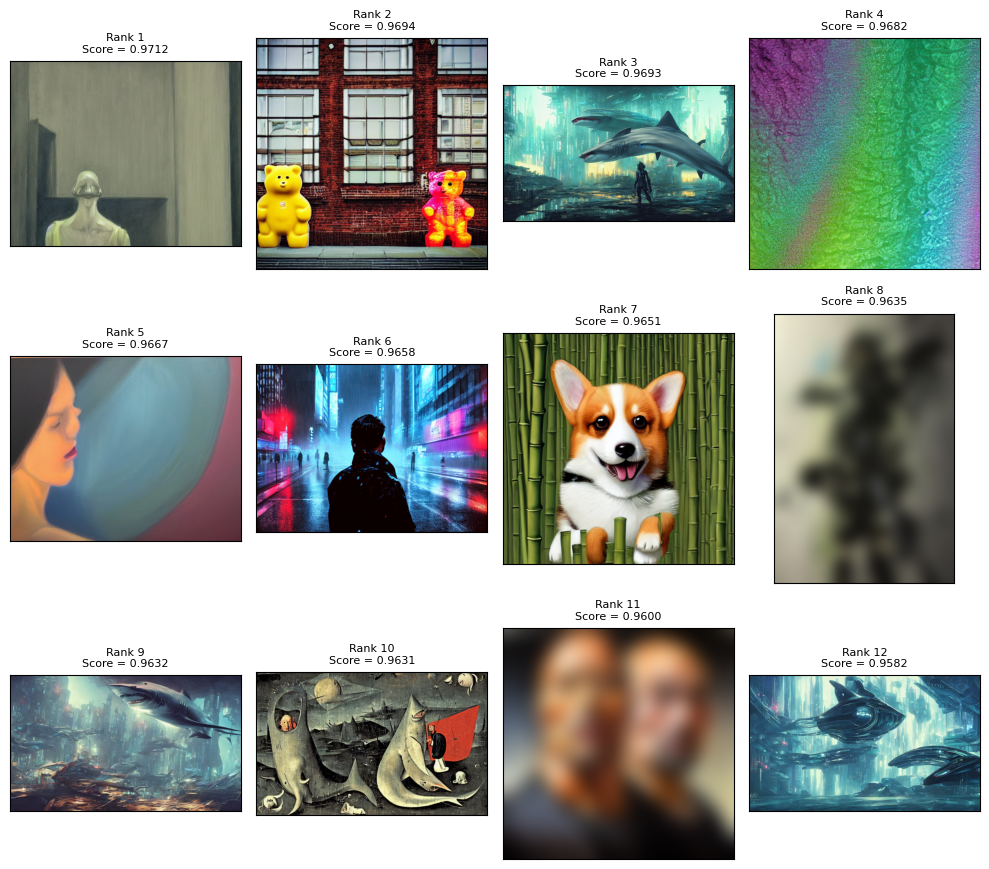

In [34]:
import matplotlib.pyplot as plt
from PIL import Image
import math
import os

if search_successful and search_results:
    print("\nVisualizing search results...")

    try:
        sorted_results = sorted(search_results, key=lambda x: x.distance, reverse=True)
    except Exception as e:
        print(f"Error sorting results: {e}")
        sorted_results = search_results


    MAX_IMAGES_DISPLAY_SEARCH = 12
    images_to_display = []

    if 'image_directory' in globals() and image_directory:
        for result in sorted_results[:MAX_IMAGES_DISPLAY_SEARCH]:
            try:
                image_id = result.id
                score = result.distance
                original_image_path = os.path.join(image_directory, image_id)

                if os.path.exists(original_image_path):
                    images_to_display.append((original_image_path, score))
                else:
                    images_to_display.append((None, score))

            except Exception as e:
                print(f"Error processing result for display: {result} - {e}")
                images_to_display.append((None, None))

    else:
        print("Visualization skipped: 'image_directory' variable is not defined.")

    if images_to_display:
        num_cols_display_search = 4
        num_rows_display_search = math.ceil(len(images_to_display) / num_cols_display_search)

        try:
            fig, axs = plt.subplots(nrows=num_rows_display_search, ncols=num_cols_display_search, figsize=(10, num_rows_display_search * 3))

            if num_rows_display_search == 1 and num_cols_display_search == 1:
                axs = [axs]
            else:
                axs = axs.flatten()

            for i, (image_path, score) in enumerate(images_to_display):
                ax = axs[i]

                if image_path and os.path.exists(image_path):
                    try:
                        image = Image.open(image_path).convert('RGB')
                        ax.imshow(image)
                        title = f"Rank {i+1}\nScore = {score:.4f}" if score is not None else f"Rank {i+1}"
                        ax.set_title(title, fontsize=8)
                    except Exception as e:
                        ax.set_title(f"Rank {i+1}\nError Loading", fontsize=8)
                        ax.text(0.5, 0.5, 'Load Error', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color='red')
                        print(f"Plotting Error: Could not load/display image {image_path} - {e}")

                else:
                    title = f"Rank {i+1}\nScore = {score:.4f}" if score is not None else f"Rank {i+1}"
                    ax.set_title(f"{title}\n(Image Not Found)", fontsize=8)
                    ax.text(0.5, 0.5, 'Missing', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                    ax.set_facecolor('#e0e0e0')

                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlabel('')
                ax.set_ylabel('')

            for j in range(len(images_to_display), len(axs)):
                fig.delaxes(axs[j])

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Plotting failed: Error setting up plot - {e}")

elif search_successful and not search_results:
    print("Search successful, but no results returned to visualize.")
else:
    print("Skipping visualization because search was not successful.")